In [1]:
# Import relevant libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2

# import the urllib library
import urllib.request
import os #For checking if a file exists

C:\Users\thuit\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


#### We will be testing a model that combines the wave and image data to see if this offers improved performance over either of the other data when they are trained on alone.

# Set up the data

In [2]:
# Cres0
images0=np.load("cresSpect0.npy")
waves0=np.load("cresWave0.npy")
#And read in the meta data
df0=pd.read_csv("cresSpectMeta0.csv")
print('images0 has shape: ', np.shape(images0))

# Cres 1
images1=np.load("cresSpect1.npy")
waves1=np.load("cresWave1.npy")
#And read in the meta data
df1=pd.read_csv("cresSpectMeta1.csv")
print('images1 has shape: ', np.shape(images0))

# Concatenate images
images = np.zeros((2000, 600, 100)) # Pre-allocate for speed
images = np.concatenate((images0, images1), axis=0)
print('total concatenated images array has shape: ', np.shape(images0))

# Concatenate waves
#waves = waves0
#df = df0
waves = np.zeros((2000, 200000)) # Pre-allocate for speed
waves = np.concatenate((waves0, waves1), axis=0)
print('total concatenated waves array has shape: ', np.shape(waves))

images0 has shape:  (1000, 600, 100)
images1 has shape:  (1000, 600, 100)
total concatenated images array has shape:  (1000, 600, 100)
total concatenated waves array has shape:  (2000, 200000)


## Set up labels

In [3]:
# Set up time and freq arrays
t0_array_cres0 = df0['t0s']*1e3
f0_array_cres0 = df0['f0s']/1e6

t0_array_cres1 = df1['t0s']*1e3
f0_array_cres1 = df1['f0s']/1e6



# Concatenate arrays
t0_array = np.concatenate((t0_array_cres0, t0_array_cres1), axis=0)
f0_array = np.concatenate((f0_array_cres0, f0_array_cres1), axis=0)



# Normalise arrays
t0_array_max = np.max(t0_array)
f0_array_max = np.max(f0_array)

t0_array_normalised = t0_array/t0_array_max
f0_array_normalised = f0_array/f0_array_max



# Show shapes of arrays
print('t0 array shape: ', np.shape(t0_array_normalised))
print('f0 array shape: ', np.shape(f0_array_normalised))



# Stack data:
labels = np.stack((t0_array_normalised, f0_array_normalised), axis = 1)
print('Stacked labels shape:', np.shape(labels))

t0 array shape:  (2000,)
f0 array shape:  (2000,)
Stacked labels shape: (2000, 2)


## Normalise the data

In [4]:
# Pre-allocate array for speed
normed_waves = np.zeros((2000, 200000))
normed_images = np.zeros((2000, 600, 100))

for i in range(2000):
    normed_waves[i] = waves[i]/np.max(abs(waves[i]))
    normed_images[i] = images[i]/np.max(images[i])

## De-noise images

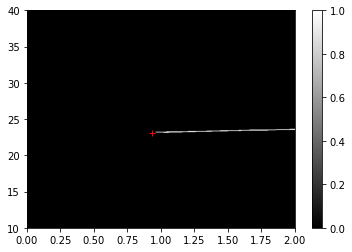

In [5]:
de_noised_images = np.zeros((2000, 600, 100))

for i in range(2000):
    image = np.array(normed_images[i])
    kernel_size = 8 
    kernel = np.ones((1, kernel_size)) / kernel_size
    
    filtered_image = cv2.filter2D(image, -1, kernel) # Apply filter using cv2.filter2D
    blur_kernel_size = (5, 5) # Blur size
    blurred_image = cv2.GaussianBlur(filtered_image/np.max(filtered_image), blur_kernel_size, 0) # Apply Gaussian blur
    
    threshold_value = 0.6 # Define threshold value
    thresholded_image = np.where(blurred_image/np.max(blurred_image) < threshold_value, 0, blurred_image/np.max(blurred_image)) # Threshold the image
    
    de_noised_images[i] = thresholded_image/np.max(thresholded_image) # Append and normalise



# Turn every non zero value into 1
de_noised_images[de_noised_images != 0] = 1



# Test an image:
whichImage = 1500

plt.imshow(de_noised_images[whichImage], cmap='gray', extent=[0,2,10,40], aspect='auto', origin='lower')
plt.plot(labels[whichImage, 0]*t0_array_max, labels[whichImage, 1]*f0_array_max, 'r+')
plt.colorbar()

# Test a non-convolutional neural network

In [7]:
num_samples = 1700  # Number of training samples

train_waves = normed_waves[:num_samples]  # Create waves training sample, shape (num_samples, 200000)
train_images = de_noised_images[:num_samples] # Create images training sample, shape (num_samples, 600, 100)
train_labels = labels[:num_samples]  # Training labels, shape (num_samples, 2)



val_waves = normed_waves[num_samples:]  # Create waves validation sample
val_images = de_noised_images[num_samples:] # Create images validation sample
val_labels = labels[num_samples:]  # Validation labels



# Reshape the data to match expected input shape
train_waves_reshaped = np.expand_dims(train_waves, axis=-1)
train_images_reshaped = np.reshape(train_images, (num_samples, 600, 100, 1))


val_waves_reshaped = np.expand_dims(val_waves, axis=-1)
val_images_reshaped = np.reshape(val_images, (2000-num_samples, 600, 100, 1))

In [11]:
# Define input layers for each type of data
input_wave = keras.layers.Input(shape=(200000, 1))
input_image = keras.layers.Input(shape=(600, 100, 1))



# Define the CNN for image data
flatten_layer = keras.layers.Flatten()(input_image)
dense_layer_image = keras.layers.Dense(128, activation='relu')(flatten_layer)
dense_layer_image = keras.layers.Dropout(0.3)(dense_layer_image)
dense_layer_image = keras.layers.Dense(1024, activation='relu')(dense_layer_image)
dense_layer_image = keras.layers.Dropout(0.3)(dense_layer_image)
dense_layer_image = keras.layers.Dense(1024, activation='relu')(dense_layer_image)

# Define the CNN for waveform data
flatten_wave = keras.layers.Flatten()(input_wave)
dense_layer_wave = keras.layers.Dense(64, activation='relu')(flatten_wave)
dense_layer_wave = keras.layers.Dropout(0.3)(dense_layer_wave)
dense_layer_wave = keras.layers.Dense(1024, activation='relu')(dense_layer_wave)
dense_layer_wave = keras.layers.Dropout(0.3)(dense_layer_wave)
dense_layer_wave = keras.layers.Dense(1024, activation='relu')(dense_layer_wave)

# Concatenate the output from both CNNs
concatenated = keras.layers.concatenate([dense_layer_image, dense_layer_wave])

# Final output layer
output = keras.layers.Dense(2, activation='sigmoid')(concatenated)

# Create model
model = keras.models.Model(inputs=[input_wave, input_image], outputs=output)

# Compile model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])



# Train the model
history = model.fit([train_waves_reshaped, train_images_reshaped], train_labels, epochs=10, batch_size=32,
                    validation_data = ([val_waves_reshaped, val_images_reshaped], val_labels))

Epoch 1/10
54/54 [==============================] - 12s 203ms/step - loss: 0.0466 - accuracy: 0.8424 - val_loss: 0.0294 - val_accuracy: 0.8267
Epoch 2/10
54/54 [==============================] - 9s 171ms/step - loss: 0.0313 - accuracy: 0.8671 - val_loss: 0.0309 - val_accuracy: 0.8233
Epoch 3/10
54/54 [==============================] - 9s 171ms/step - loss: 0.0114 - accuracy: 0.8859 - val_loss: 0.0240 - val_accuracy: 0.8233
Epoch 4/10
54/54 [==============================] - 9s 172ms/step - loss: 0.0072 - accuracy: 0.9106 - val_loss: 0.0247 - val_accuracy: 0.8233
Epoch 5/10
54/54 [==============================] - 9s 172ms/step - loss: 0.0054 - accuracy: 0.9265 - val_loss: 0.0243 - val_accuracy: 0.8233
Epoch 6/10
54/54 [==============================] - 9s 172ms/step - loss: 0.0048 - accuracy: 0.9335 - val_loss: 0.0227 - val_accuracy: 0.8300
Epoch 7/10
54/54 [==============================] - 9s 172ms/step - loss: 0.0043 - accuracy: 0.9312 - val_loss: 0.0212 - val_accuracy: 0.8300
Epoch

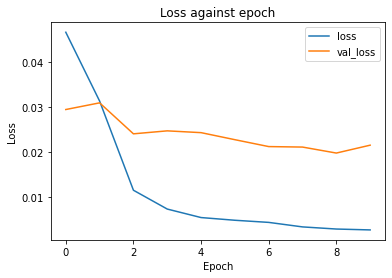

In [12]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.title('Loss against epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# To test this model, garbage collection will be required. This allows us to free up memory to make predictions on the data, as this model is  very computationally expensive, and takes up a large amount of memory.

In [13]:
# Garbage collection to free memory
import gc

# Clear variables to free memory
del train_waves
del train_images
del train_labels

del train_waves_reshaped
del train_images_reshaped

del normed_images

del t0_array_cres0
del f0_array_cres0

del t0_array_cres1
del f0_array_cres1

del t0_array
del f0_array

# Garbage collection
gc.collect()

1741

In [14]:
num_samples = 2000 # Number of prediction samples to test the model

test_images = de_noised_images[:num_samples]
test_images_reshaped = np.reshape(test_images, (num_samples, 600, 100, 1))

test_waves = normed_waves[:num_samples]
test_waves_reshaped = np.expand_dims(test_waves, axis=-1)

predictions = model.predict([test_waves_reshaped, test_images_reshaped])

63/63 [==============================] - 1s 17ms/step


In [15]:
# Calculate squared differences between the coordinates
squared_diff = np.sum(abs(predictions - labels) ** 2, axis=1)

# Take square root of the sum to get distance
distances = np.sqrt(squared_diff)



print('Mean distance for train data: ', np.mean(distances[:1700]))
print('Standard deviation for train data: ', np.std(distances[:1700]))
print(' ') # Blank line
print('Mean distance for validation data: ', np.mean(distances[1700:]))
print('Standard deviation for validation data: ', np.std(distances[1700:]))

Mean distance for train data:  0.048677623048645945
Standard deviation for train data:  0.02690091211014161
 
Mean distance for validation data:  0.17529319605652205
Standard deviation for validation data:  0.11051369580944596


#### This model overfits significantly. However, it does exceptionally well on the training data. Hence, with further research, this model could prove extremely effective on unseen data. It also runs very quickly, so it could be well suited as a general purpose prediction model, being both fast and accurate.